<a href="https://colab.research.google.com/github/VladislavTumanov/bookish-computing-machine/blob/main/Credit_scoring_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import warnings
import io 
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [2]:
import warnings
warnings.filterwarnings("ignore")

#function which is used when need NaN value replace on median
def delete_nan(table):
    for col in table.columns:
        table[col] = table[col].fillna(table[col].median())
    return table

In [3]:
from google.colab import files
uploaded = files.upload()

Saving credit_scoring_sample.csv to credit_scoring_sample.csv


In [4]:
data = pd.read_csv((io.BytesIO(uploaded['credit_scoring_sample.csv'])), sep=";")
data

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0
...,...,...,...,...,...,...,...,...
45058,1,31,0,0.824725,0,0,3000.0,1.0
45059,0,49,0,6530.000000,0,0,0.0,5.0
45060,1,38,0,0.475841,0,0,3000.0,2.0
45061,0,47,1,0.485198,0,0,11720.0,5.0


In [5]:
for i in data.columns:
  print(i, 'number of nan is',sum(np.isnan(data[i])))

SeriousDlqin2yrs number of nan is 0
age number of nan is 0
NumberOfTime30-59DaysPastDueNotWorse number of nan is 0
DebtRatio number of nan is 0
NumberOfTimes90DaysLate number of nan is 0
NumberOfTime60-89DaysPastDueNotWorse number of nan is 0
MonthlyIncome number of nan is 8643
NumberOfDependents number of nan is 1117


In [6]:
data.describe()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
count,45063.000000,45063.000000,45063.000000,45063.000000,45063.000000,45063.000000,3.642000e+04,43946.000000
mean,0.222489,51.210949,0.750993,352.062688,0.570712,0.505870,6.452263e+03,0.789628
std,0.415922,14.651533,6.184521,2467.556358,6.173106,6.153609,1.263817e+04,1.130813
min,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,0.000000,40.000000,0.000000,0.176373,0.000000,0.000000,3.286000e+03,0.000000
50%,0.000000,51.000000,0.000000,0.373949,0.000000,0.000000,5.166000e+03,0.000000
75%,0.000000,62.000000,0.000000,0.857027,0.000000,0.000000,8.000000e+03,1.000000
max,1.000000,107.000000,98.000000,326442.000000,98.000000,98.000000,1.794060e+06,10.000000


In [7]:
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

In [8]:
np.unique(data['SeriousDlqin2yrs'])

array([0, 1])

<Axes: >

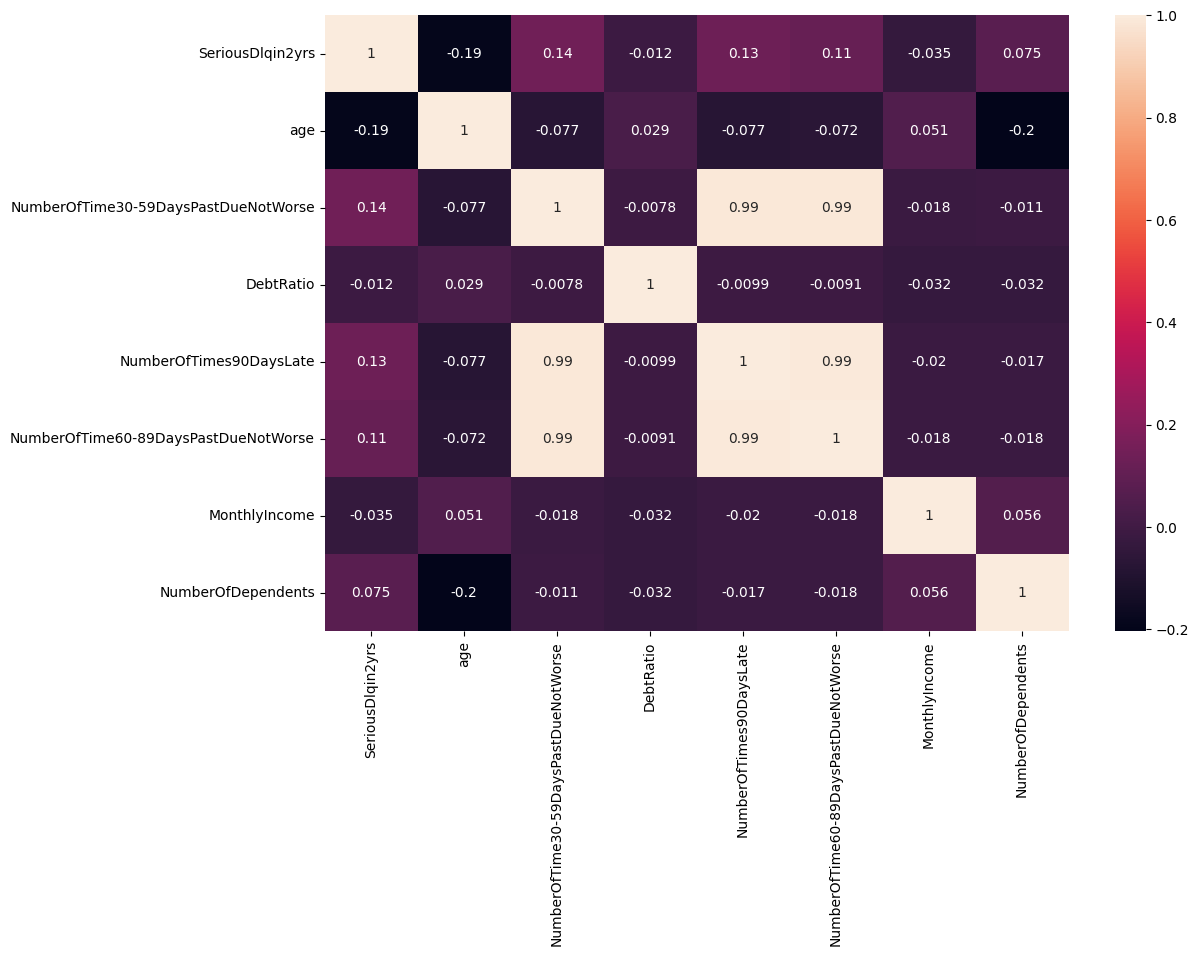

In [9]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(data.corr(), annot = True)

In [11]:
table = delete_nan(data)

In [12]:
X = table[independent_columns_names]
y = table['SeriousDlqin2yrs']

In [13]:
#function for genetare samples with bootstrap
def get_bootstrap_samples(info, n_sample):
  indicates = np.random.randint(0, len(info), (n_sample, len(info)))
  samples = info[indicates]
  return samples

# function for determine interval estimation
def stat_intervals(stat, alpha):
  boundaries = np.percentile(stat,[100*alpha/2, 100*(1-alpha/2)])
  return boundaries

churn_debt = data[data['SeriousDlqin2yrs']==1]['age'].values

np.random.seed(0)

churn_mean_scores = [np.mean(sample) for sample in get_bootstrap_samples(churn_debt, 1000)]

print("Service calls from churn:  mean interval", stat_intervals(churn_mean_scores, 0.1))

Service calls from churn:  mean interval [45.71379414 46.12700479]


As a result, we got that with 90% probability the average age of the client who has not paid the debt will be in the range between 45 and 46

In [16]:
#Define outliers
for i in table.columns:
  table.sort_values(by = i, ascending= True, na_position = 'last')
  q1,q3 = np.percentile(table[i], [25,75])
  screw = q3 - q1
  low_bound = q1 - 1.5*screw
  up_bound = q3 + 1.5*screw
  outliers_values = table[i][(low_bound > table[i]) | (up_bound < table[i])]
  perc_outliers = (outliers_values.count()/table[i].count())*100
  print('Outliers in %s is %.2f%% with count %.f' %(i,perc_outliers, outliers_values.count()))

Outliers in SeriousDlqin2yrs is 22.25% with count 10026
Outliers in age is 0.05% with count 23
Outliers in NumberOfTime30-59DaysPastDueNotWorse is 21.57% with count 9722
Outliers in DebtRatio is 20.29% with count 9142
Outliers in NumberOfTimes90DaysLate is 10.44% with count 4704
Outliers in NumberOfTime60-89DaysPastDueNotWorse is 8.80% with count 3967
Outliers in MonthlyIncome is 6.45% with count 2906
Outliers in NumberOfDependents is 9.45% with count 4260


In [25]:
for i in table.columns:
  table.sort_values(by = i, ascending= True, na_position = 'last')
  q1,q3 = np.nanpercentile(table[i], [25,75])
  screw = q3-q1
  low_bound = 1.5*q1 - (1.5*screw)
  upp_bound = 1.5*q3 + (1.5*screw)
  mean = table[i].mean()
  table.loc[table[i] < low_bound, [i]] = mean
  table.loc[table[i] > upp_bound, [i]] = mean
  table.loc[table[i] < low_bound, [i]] = mean
  table.loc[table[i] > upp_bound, [i]] = mean

In [28]:
table.describe()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
count,45063.000000,45063.000000,45063.000000,45063.000000,45063.000000,45063.000000,45063.000000,45063.000000
mean,0.049501,52.037307,0.162021,70.362949,0.059575,0.044533,5660.131888,0.670776
std,0.092538,13.845531,0.308914,140.435491,0.174504,0.143336,2788.084953,0.940924
min,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,486.000000,0.000000
25%,0.000000,42.000000,0.000000,0.176373,0.000000,0.000000,3900.000000,0.000000
50%,0.000000,51.210949,0.000000,0.373949,0.000000,0.000000,5166.000000,0.000000
75%,0.000000,62.000000,0.000000,0.857027,0.000000,0.000000,6669.000000,1.000000
max,0.222489,107.000000,0.750993,352.062688,0.570712,0.505870,15776.000000,3.000000


In [23]:
# Define p-value for each feature
X = table.iloc[: , : -1]

regressor_OLS = sm.OLS(endog=table['SeriousDlqin2yrs'], exog= X).fit()
max_pvalue = max(regressor_OLS.pvalues)
pvalues = regressor_OLS.pvalues
pvalues[pvalues > 0.05]

age                                     0.503870
NumberOfTime30-59DaysPastDueNotWorse    0.993916
NumberOfTimes90DaysLate                 0.857286
NumberOfTime60-89DaysPastDueNotWorse    0.875389
dtype: float64

In [33]:
X_train, X_test, y_train, y_test   = train_test_split(X, y, test_size=0.3, random_state=17)
scaled = StandardScaler()
X_train_scaled = scaled.fit_transform(X_train)
X_valid_scaled = scaled.transform(X_test)

# Logistic Regression

In [96]:
lr = LogisticRegression(random_state=5, class_weight="balanced", penalty='l1', solver='saga')
parameters = {"C": (0.0001, 0.001, 0.01, 0.1, 1, 10)}
skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 5)

In [97]:
grid = GridSearchCV(lr, parameters, scoring ='roc_auc', cv=skf, n_jobs = -1)
grid.fit(X, y)
grid.best_estimator_

LogisticRegression(C=10, class_weight='balanced', penalty='l1', random_state=5,
                   solver='saga')

In [98]:
print(grid.cv_results_['std_test_score'])
grid.best_score_

[0.00403729 0.00403116 0.00403277 0.00403336 0.00403339 0.0040334 ]


0.573004772178881

In [117]:
lr = LogisticRegression(C = 10,random_state=5, class_weight="balanced")
sc = StandardScaler()
X_norm = sc.fit_transform(X)
lr.fit(X_norm, y)

pd.DataFrame({'features' : independent_columns_names, 'coef': lr.coef_.flatten().tolist()}).sort_values(by = 'coef',  ascending=False)

,features,coef
0,age,9.110065
2,DebtRatio,0.145653
4,NumberOfTime60-89DaysPastDueNotWorse,0.053875
3,NumberOfTimes90DaysLate,-0.014717
6,NumberOfDependents,-0.054522
5,MonthlyIncome,-0.086907
1,NumberOfTime30-59DaysPastDueNotWorse,-0.214511


# Random Forest

In [ ]:
rf = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=42,
    oob_score=True,
    class_weight="balanced",
)

parameters = {
    "max_features": [1, 2, 4],
    "min_samples_leaf": [3, 5, 7, 9],
    "max_depth": [5, 10, 15],
}

skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 5)

gs = GridSearchCV(rf, parameters, n_jobs = - 1, scoring ='roc_auc', cv=skf)
gs.fit(X,y)
gs.best_score_

0.8357785379863423

In [ ]:
gs.best_estimator_
#The model with the best result has the following parameter

RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=2,
                       min_samples_leaf=9, n_jobs=-1, oob_score=True,
                       random_state=42)

In [ ]:
rf = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=42,
    oob_score=True,
    class_weight="balanced",
    max_depth=10,
    max_features=2,
    min_samples_leaf=9)

rf.fit(X,y)

independent_columns_names[np.argmin(rf.feature_importances_)]

'NumberOfDependents'

In [ ]:
parameters = {
    "max_features": [2, 3, 4],
    "max_samples": [0.5, 0.7, 0.9],
    "base_estimator__C": [0.0001, 0.001, 0.01, 1, 10, 100],
}

bg = BaggingClassifier(LogisticRegression(class_weight='balanced'), n_estimators=100, n_jobs=-1, random_state=42)

r_grid_search = RandomizedSearchCV(bg,parameters, n_jobs=-1, scoring ='roc_auc', random_state=42, n_iter=20, cv = skf, verbose=True)

r_grid_search = r_grid_search.fit(X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [ ]:
r_grid_search.best_score_

0.8085323694398069